In [1]:
import numpy as np
import pylab as pl
from collections import namedtuple
import pickle

In [2]:
def kabsch_template_alignment(p1,p2,t1,t2):
    ''' given a matched pair of templates, it computes the optimal superposition rotation and translation
        this is then applied to the coordinates in P1 and P2.  the inputs are not modified'''
    R,w,d,offset1,offset2 = kabsch(t1,t2)
    return  p1-offset1,np.matmul(p2-offset2,R.T),(R,w,d,offset1,offset2)



def kabsch(p1,p2):
    '''INPUTS: points1,2 are kxN where k is the dimesion of the coortinates (e.g. 3D) and N is the number of points.

OUTPUTS:  RMSD minimizing rotation matrix and the eigen values.
To get the RMSD then apply the rotation like this: 
    np.sum((np.matmul(p1,R)-p2)**2) to rotate p1 onto p2
    np.sum((np.matmul(p2,R.T)-p1)**2)to rotate p2 onto p1  
First Author: Charlie E. M Strauss 2020'''
     
    # center both arrays on COM
    # this also makes a copy so as not to modify inputs
    offset1 = np.mean(p1,axis=0)
    offset2 = np.mean(p2,axis=0)
    points1=p1-offset1
    points2=p2-offset2

    return (*kabsch_modify(points1,points2,centerCOM=False),offset1,offset2)
   
def kabsch_modify(points1,points2,centerCOM=True, epsilon=1E-16):
    '''INPUTS: points1,2 are kxN where k is the dimesion of the coortinates (e.g. 3D) and N is the number of points.

MODIFIES INPUTS: The arrays will be modified unless centerCOM is false! 
The kabsch method requires centered arrays and thus perfroms this centering in-place unless
    the COM position <epsilon (i.e. close enough to zero).  
But if you already centered them beforehand the optionally overide this
    by setting centerCOM=False.

OUTPUTS:  RMSD minimizing rotation matrix and the eigen values.
To get the RMSD then apply the rotation like this: 
    np.sum((np.matmul(p1,R)-p2)**2) to rotate p1 onto p2
    np.sum((np.matmul(p2,R.T)-p1)**2)to rotate p2 onto p1  
First Author: Charlie E. M Strauss 2020'''
     
    if centerCOM:
        t = np.mean(points1,axis=0)
        if np.any(abs(t)>epsilon):
            points1-= t
        t = np.mean(points2,axis=0)
        if np.any(abs(t)>epsilon):
            points2-= t
    
    H =  np.matmul(points1.T,points2)
    V,w,U =np.linalg.svd(H)

    R = np.matmul(V,U)
    d=np.sign(np.linalg.det(R)) # check to make sure rotation is proper and not an inversion.
                               # this happens mainly when structures are not similar, but it does happen!
    if d==-1:  
        # fix improper rotation.  It's not intuitvley obvious why the best proper rotation is a sign flip on U but it is. how convenient!
         U[-1,:]=-U[-1,:]   # note!  or NOT this:  U[:,-1] 
         R = np.matmul(V,U)
    
    return R,w,d

                  

### make two similar proteins that are the same size but not identical
This is a random walk that uses three tricks.  It's an acceleration random walk, so the integrated paths tend to go in one directions and olny slowly turn. The paths are encouraged to loop back on themselves by damping on the distance from the origin.  And the steps are encouraged not to grow to large by damping on the velocity, and also by running the velocity through a tanh filter scales to try to keep it within bounds.
A random set of acelerations defines the basic backbone, but the ttwo proteins have perturbations on this basic acceleration field.  This is better than simply adding nois the positions because for the above reasons the paths will have different arcs rather than being simply noise about the same central path.

array([0.        , 0.22428144, 0.14817199, 0.37149601, 0.82425086,
       0.42227396, 0.38943859, 0.51886926, 0.50981331, 0.25909008,
       0.83995655, 1.0447182 , 2.05233466, 3.04911055, 1.80922289,
       2.6496286 , 0.44355895, 1.50643421, 2.1086548 , 2.40594299,
       0.95514732, 0.97297931, 0.64275922, 0.58200164, 1.11969811,
       1.45631548, 1.16579459, 1.17590663, 1.34108709, 0.48845494,
       0.6483748 , 2.30546683, 1.14844199, 1.50697108, 1.21331848,
       0.7327481 , 1.12539859, 1.78283113, 2.49753416, 3.07379191,
       1.97665175, 1.16114019, 1.29996271, 0.42006203, 0.86126393,
       0.79142826, 1.82071257, 1.38298623, 3.0227347 , 2.68632864,
       1.96816373, 1.28956891, 0.8765937 , 2.20185416, 3.13259964,
       3.18768108, 2.66913127, 1.23663633, 0.47974944, 1.70609718,
       1.29120483, 1.82849332, 0.55615706, 0.29384314, 1.06926259,
       1.79093561, 1.22718591, 0.42490359, 1.24759167, 1.18188998,
       1.18054427, 0.28411209, 1.56516695, 2.06657698, 2.61138

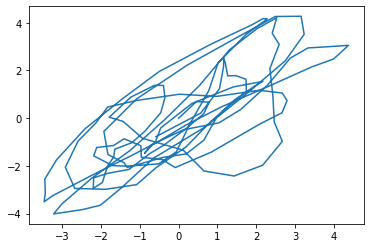

In [3]:
nr=150
a1 = []
p00 =np.random.random([nr,3])-0.5
p20 = np.random.random([nr,3])-0.5
p21=np.random.random([nr,3])-0.5
c1=0
c2=0
p20[0]=p21[0]=p00[-1]*0
v0=v1=p00[-1]*0
for i in range(1,nr):  

    p20[i]=p20[i-1]+v0
    p21[i]=p21[i-1]+v1
    v0=np.tanh(0.5*(v0+p00[i]-0.05*v0**3-0.15*(p20[i]+5*(np.random.random(3)-0.5))))*2
    v1=np.tanh(0.5*(v1+p00[i]-0.05*v0**3-0.15*(p21[i]+5*(np.random.random(3)-0.5))))*2
0.05564091
    
    
pl.plot( p20[:,1],p21[:,1] )
np.sum((p20[1:]-p20[0:-1])**2,axis=1)

### now we trim long loops off one of the proteins.
we iterate along the protein from N to c and loop for places the path seems to close back on itself within 14 residues.  We then trim out that loop.  This process is applies to only one of the proteins.  You could do it to both you wanted but the book-keeping becomes a headache.  The goal is just to create two proteins of different length and also an exaclty known alignment of residues.
the alignment is a 2xK array a1 where K is the number of aligned residues (the number of the smaller protein size). It's a list of corresponding indicies in the original list of atom positions.

In [4]:
a1=[]
c1=i=0
lastbreak=-8
while c1<np.shape(p20)[0]:
    if c1-lastbreak >20:
        for j in range(4,14):
            if i+j>=np.shape(p21)[0]: break
            if 4>np.sum((p21[i]-p21[j+i])**2):
  
     
                p21=np.delete(p21,np.arange(i,i+j),axis=0)
                c1+=j
                lastbreak = c1
  
    a1.append([c1,i])

    
    i+=1
    c1+=1
a1 = np.array(a1).T             
a1           

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
         37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149],
       [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  6

#### lets see what the alignment looks like
note because of the construction, their are usually no gaps in the N terminal.  sure that's an artficact but remember this is just for testing the logic of the program not to create real proteins

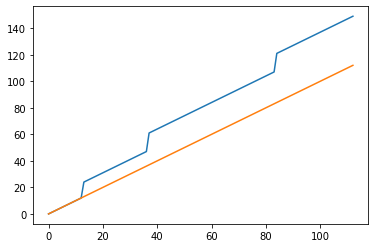

In [5]:
pl.plot(a1.T)

####  plot Y-coord of one protein against the other. 
The more this lies off the diagonal the more perturbed they are

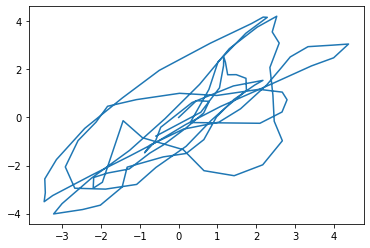

In [6]:

pl.plot( p20[a1[0],1],p21[a1[1],1] )

#### plot the x-coord of just the aligned residues in the two proteins

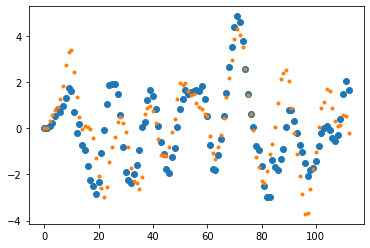

In [7]:
pl.plot(p20[a1[0],0],"o")
pl.plot(p21[a1[1],0],".")

#### plot X-Y trace of both proteins then overlay them

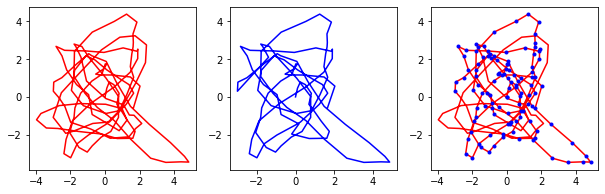

In [8]:
pl.figure(figsize=(3*(3+0.4),3))
pl.subplot(1,3,1)
pl.plot(p20[:,0],p20[:,1],'r')
pl.subplot(1,3,2)
pl.plot(p20[a1[0],0],p20[a1[0],1],"b")
pl.subplot(1,3,3)
pl.plot(p20[:,0],p20[:,1],'r')
pl.plot(p20[a1[0],0],p20[a1[0],1],"b.")


In [9]:
#Metrics = namedtuple('Metrics',['TM','PSI','aPSI','rPSI','cRMS','aRMS','oRMS','aSeq_ident','oSeq_ident','cSeq_Ident','L_min','L_aligned','L_orientable','L_PSI'])                              
MAXSUB_TM= namedtuple('MAXSUB_TM',('score','rotation','alignment','alignedRMS'))
#Process = namedtuple('Process',('name','tm_alignment','maxsub_alignment','tm_metric','maxsub_metric','strong_metric','weak_metric'))

                         

def FR_TM_maxsub_score(master_p0, master_p1,align_index,
          FRAGSMALL=8,FRAGLARGE=12,TOL=7.0, UNIT = 1.0, debug=0 ):
    '''Inputs:
    master_pX Nxk points list where k=3 for 3D, and N is all points.
    align_index[X][i] translates i'th alingment point to the index in master
    
    '''
    RMSTOL = TOL*UNIT   #######  CHECK THIS IS THE RIGHT DEFAULT VALUE
    L_aligned=np.shape(align_index)[1]
    L_min = min( np.shape(master_p0)[0],np.shape(master_p1)[0])  # get the shape
    assert(L_min >9)
    
    TM_d0 = 1.24*(L_min-15)**0.333333 -1.8  # for the TM score
    TM_d02 = TM_d0**2
    FRAGSIZE =FRAGSMALL if L_min <100 else FRAGLARGE
    FRAGSIZE=7    
    
    N = np.shape(align_index)[1]
    WINDOWS = N-FRAGSIZE # +1 ?
    # grab the aligned residues out of the master lists.
 #   print("P0 shape {} {}".format(np.shape(master_p0),align_index[0,-1]))
 #   print("P1 shape {} {}".format(np.shape(master_p1),align_index[1,-1]))
 #   print(align_index)
    p0 = master_p0[align_index[0]]
    p1 = master_p1[align_index[1]]
    
    
    # set accumulation variables to default or triggers to replace them later
    maxsub_most = -1 # or  0?
    maxsub_alignedRMS = 1E9*UNIT
    maxsub_alignment=[]
    maxsub_rotation = np.eye(3)         
    
    raw_TM_score_best=maxsub_TM_score_best=1E9*UNIT
 
    
    # initialize 
    raw_TM_score_best = -1 # an illegally large value so it will get forced to be replaced below
    maxsub_TM_best_rotation=raw_TM_best_rotation = np.array([[1.0,0,0],[0,1.0,0.0],[0,0,1.0]]) # no rotation at all.
    maxsub_TM_score_best = -1
    maxsub_TM_most = -1
    
    longest_TM_best_rotation=raw_TM_best_rotation = np.array([[1.0,0,0],[0,1.0,0.0],[0,0,1.0]]) # no rotation at all.
    longest_TM_score_best = -1
    longest_TM_most = -1

    # loop over all initial seeds for rotation based on consecutive fragments.
    
    for i0 in range( WINDOWS):
        frg = range(i0,i0+FRAGSIZE)
        frag0 = p0[frg]
        frag1 = p1[frg]

        p0aligned,p1aligned,G=kabsch_template_alignment(p0,p1,frag0,frag1)
      #  R,w,d,offset0,offset1 = kabsch(frag0,frag1) # just align this fragment

       # p1aligned = np.matmul(p1-offset1,R.T) # apply alignment.

        # The initial alginment  might be okay, so lets record it
        deviation2 = np.sum((p0aligned-p1aligned)**2,axis=1) # only sum over x,y,z but not over points.
        raw_TM_score_temp = np.sum(1.0/(1.0+deviation2/TM_d02 ))/L_min # can use L_target instead of L_min for one-to-many
    #    print ("iitial fragment msd ",np.sum(deviation2)/FRAGSIZE)
    #    print (align_index[:,i0:i0+FRAGSIZE])
        raw_rmsd_temp= np.sqrt(np.mean(deviation2))
        if  raw_rmsd_temp>=RMSTOL : next  # don't even bother!  (not a problem for mammoth but is for arbitrary alignments)
           

        if  raw_TM_score_temp> raw_TM_score_best:
             raw_TM_score_best = raw_TM_score_temp
             raw_TM_best_rotation = G
             raw_TM_best_seed_alignment = frg 
             raw_TM_alignedRMS=raw_rmsd_temp
            
        if  raw_TM_score_temp> maxsub_TM_score_best:
             maxsub_TM_score_best = raw_TM_score_temp
             maxsub_TM_best_rotation = G
             maxsub_TM_best_seed_alignment = frg
             maxsub_TM_alignedRMS = raw_rmsd_temp
        #now lets apply some maxsub style iterations to improve this
        
        
        
        #fragment_indicies=range(i0,i0+FRAGSIZE) # put current fragment indicies in list
        last_pair_count = 0
        indicies= [] #list(fragment_indices) # copy current fragment indicies in list
#### note maybe we should insert the fragment because if t==0.1 then some of the fragment won'g go in!!!!!!
#########################
        TM_temp =0.0
        # for TM_align it makes sense to make TOL larger since we want it to keep searching longer.
        t = 0.0  #################  nayve we should start this at 1???/
        while t<TOL:  # this goes one unit over TOL.  should we fix that?
          #  t+=UNIT  # e.g. one angstrom  # maybe I don't need this at all????  better without it?
            t+=0.1 #0.25*UNIT
            t2 = t*t # squared radius
            # this embeds a logic error in mammoth!  need to fix that!The percentage of structural similarity (PSI) is defined as the number of aligned amino acid pairs with Cα atoms that are closer in space then 4 Å after 
            # problem happens if NO residues get included on first pass
            # then the t gets raised too much!
            
            min_d2 = (TOL+UNIT)*(TOL+UNIT)
       #     print("t",t) 

            # have to us a fresh copy because we will be saving this
         ####  HMMMM  should this be emptied here or up above.... interesting thought.
            #indicies= [] #list(fragment_indices) # copy current fragment indicies in list
 
            ### thought: woould it make sense to add residues to index not based on RMS but on TM-score?  Maybe not just the closest ones
            ###   but ones where the derivative of TM score is largest, dialing those in would actually improve the
            ###   TM score the most. Howver those are doing to be at the raidus d2= TM_d02  not d2~0
            
            #### thought:  apply weight matrix to the RMSD matrix composiiton so that it up weights the high TM score ones
            ####   alternative thought:  up weight the the ones that have the  highest derivative.
    
            ### insight:  weighting not only affects the rotation matrix but it also affects the translations vector.
            ###  thought:  maybe you do the first run maximizing TM score then the second run starts there and
            ####           tries maximizing according to the derivative weighting?  Maybe a linear combination of the two?
    
            

            for j0 in  range(N):  
                # check if we should include this atom pair    
                if j0 not in indicies: 
                    deviations =(p0aligned[j0]-p1aligned[j0])**2
                    d2 = np.sum(deviations)  # MSD for atom pair so it's divide by 1 not L_align
                    # include this if it is close enough or is in the fragment
                    # in the JM align, the runs of good alignment are short.  It may be better t o leave out parts of the seed
                    # fragment???????????????????????????????????????????????/
    #####                # Maybe we don't need to include the whole fragment???? is parts have a big RMS?#######
                    if d2<t2 or (0<=j0-i0<FRAGSIZE): # could use short circuit or
                        indicies.append(j0)  # change this to faster method
                #        print(align_index[:,i0:i0+FRAGSIZE])
                 #Kabsch-Copy3       print (len(indicies),t2,d2,i0,j0,align_index[:,j0],d2<t2 , (i0<=j0),j0<i0+FRAGSIZE)
                    
                   
                    
               ###  and while were at it need to fix a theoreticl chance that the RMSD of the first fragment is over RMSTOL.
            ### that wont  happen in mammoth but if there is a bad random alignment from JAMIE it might.!!!!!
            
                    else: # do not update min_d2 this for fragment itself
                        min_d2 = min(min_d2,d2) # track closest distance
                        # note this min ignores the ones in the aligned fragment.
       #     print("min_d2",min_d2,np.ceil(np.sqrt(min_d2)/UNIT)*UNIT)        
            # did we add any new atomns in last iteration?
            L_indicies = len(indicies)
            
            # here we have to be careful--- as long as indicies is strictly accumaltive then we can be sure
            # that nothing in the alignemnt was added unless  L_indicies > last_pair_count
            # but if that is NOT true, and we can remove underperforming residues as the alignment focus
            # moves to better TM scores but fewer residues then we may not trigger this 
            # since inside this we trigger the re-alignment then the evolution will stop in it's tracks!
         #   print ("L_indicies",L_indicies, last_pair_count, L_indicies- last_pair_count)
          #  if (debug==1):
         #       print('L_indicies {} last_pair_count {}'.format(L_indicies,last_pair_count))
            if  L_indicies > last_pair_count and  L_indicies >3:  #### may want to chack that have atleast 3 atoms of kabsch will barf.
                last_pair_count= L_indicies 
                p0aligned,p1aligned,G=kabsch_template_alignment(p0,p1,p0[indicies],p1[indicies])
               # R,w,d,offset0,offset1 = kabsch(p0[indicies],p1[indicies])  
                # rotation that aligns just the selected atoms
              #  p1aligned = np.matmul(p1-offset1,R.T)
                deviation2 = np.sum((p0aligned-p1aligned)**2,axis=1)  # note the sum over coords!!  # this is over the full alignment.
                alignedRMS = np.sqrt(np.mean(deviation2))  # (assumes no replicates!)
                
                # MAXSUB SCORED
                # for MAXSUB, we prefer greater number of aligned residues as long as rms<RMSTOL
        # and amoung equal number of residues we take the smaller rms.
          #      print('L_indicies {} maxsub_most {} and alignedRMS {} RMSTOL {}'.format(L_indicies,maxsub_most,alignedRMS,RMSTOL))
                if (L_indicies>maxsub_most and alignedRMS<=RMSTOL) or \
                    (L_indicies==maxsub_most and alignedRMS<maxsub_alignedRMS):
            # update the best we have0 72 seen so far
                    maxsub_most = L_indicies
                    maxsub_alignedRMS= alignedRMS  
                    maxsub_alignment= np.array(indicies)
                    maxsub_rotation = G
                
                
                #TM SCORED
                maxsub_TM_score_temp = np.sum(1.0/(1.0+deviation2/TM_d02 ))/L_min  # can use L_target instead of L_min for one-to-many
             #  print("::",np.shape(deviation2),L_min,  maxsub_TM_score_temp,"maxsub tm score best",maxsub_TM_score_best)
                # it feels wrong to divide by L_min and not L_align because it automatically upper bounds the TM_score to L_align/L_min
               
               # if (maxsub_TM_most > 3*FRAGSIZE):
                if ((L_indicies>  longest_TM_most) and  ( maxsub_TM_score_temp> 0.97*longest_TM_score_best)) or\
                   ((L_indicies<  longest_TM_most) and  ( maxsub_TM_score_temp> 1.02*longest_TM_score_best)) or\
                   ((L_indicies== longest_TM_most) and  ( maxsub_TM_score_temp>      longest_TM_score_best)):
                         longest_TM_score_best = maxsub_TM_score_temp
                         longest_TM_best_rotation = G # Do we need a copy of this? this si worthless without offset!!!!!#####
                         longest_TM_best_seed_alignment=np.array(indicies) # copy)
                         longest_TM_alignedRMS = alignedRMS
                         longest_TM_most = L_indicies
                
                if maxsub_TM_score_temp> maxsub_TM_score_best:
                       
             #   if   maxsub_TM_score_temp> maxsub_TM_score_best:
                    # print("update maxsub tm score best",maxsub_TM_score_temp)
           
                         maxsub_TM_score_best = maxsub_TM_score_temp
                         maxsub_TM_best_rotation = G # Do we need a copy of this? this si worthless without offset!!!!!#####
                         maxsub_TM_best_seed_alignment=np.array(indicies) # copy)
                         maxsub_TM_alignedRMS = alignedRMS
                         maxsub_TM_most = L_indicies
    
                # be careful with the logic of which array to rotate
            else: # nothing was close enough at this tolerance
                t =np.sqrt(min_d2)# Will also add to this 0.1*UNIT above 
            #    print("new t",t)# have to go to this far out to include another residue
                # accelerates the search a bit. But doesn'traw_TM_score_best change the outcome if you skip this step
     #   print(L_indicies,maxsub_most,alignedRMS,RMSTOL,L_indicies>maxsub_most and alignedRMS<=RMSTOL,L_indicies==maxsub_most and alignedRMS<maxsub_alignedRMS)
    #    print("L_indicies,maxsub_most,alignedRMS,RMSTOL,L_indicies>maxsub_most and alignedRMS<=RMSTOL,L_indicies==maxsub_most and alignedRMS<maxsub_alignedRMS")

        
    
    
        L_indicies = len(indicies)
  
### could the following maybe go wrong is the above isn't called?wrong.  it uses the offset for a different set sizer!!!!!!  ####$$$$$$$$$$$???????
 

        alignedRMS = np.sqrt(np.sum((p0aligned[indicies]-p1aligned[indicies])**2)/L_indicies)
        
        #### LOGIC ERROR--- WE NEED TO BE TRACKING THE maxsub score at every stage because it is
        ## # possible tha one gets to this point and alignedRMS > RMSTOL, so we won't record it 
        #####  but there might have been an intermediate stage where there was a good one less than RMSTOL but
        #####  but with fewer aligned residues.
        
        #### is this an error in mammoth too?
        
        
    # now we can pick the best trade between trying for longer and trying for the best Tm
    if longest_TM_most> maxsub_TM_most and longest_TM_score_best > 0.97*maxsub_TM_score_best:
         print ("length trade off {} residues @ Tm{} verus {} residues @ Tm{}".format(maxsub_TM_most,maxsub_TM_score_best,longest_TM_most,longest_TM_score_best))
         maxsub_TM_score_best =          longest_TM_score_best
         maxsub_TM_best_rotation =       longest_TM_best_rotation 
         maxsub_TM_best_seed_alignment=  longest_TM_best_seed_alignment
         maxsub_TM_alignedRMS =          longest_TM_alignedRMS
         maxsub_TM_most =                longest_TM_most
         
    # and as a final check we just do the full enchilada  
    if True:  # since were going to score_metric anyhow, we can skip this
        p0aligned,p1aligned,G=kabsch_template_alignment(p0,p1,p0,p1)
      #  R,w,d,offset0,offset1 = kabsch(frag0,frag1) # just align this fragment

       # p1aligned = np.matmul(p1-offset1,R.T) # apply alignment.
 
        # The initial alginment  might be okay, so lets record it
        deviation2 = np.sum((p0aligned-p1aligned)**2,axis=1) # only sum over x,y,z but not over points.
        DEBUG2_TM_score_temp = np.sum(1.0/(1.0+deviation2/TM_d02 ))/L_min # can use L_target instead of L_min for one-to-many
        #    print ("iitial fragment msd ",np.sum(deviation2)/FRAGSIZE)
        #    print (align_index[:,i0:i0+FRAGSIZE])
        raw_rmsd_temp= np.sqrt(np.mean(deviation2))


#         if  maxsub_TM_score_best < raw_TM_score_temp:
#             maxsub_TM_score_best = raw_TM_score_temp
#             maxsub_TM_best_rotation = G
#             maxsub_TM_best_seed_alignment = range(L_aligned)
#             maxsub_TM_alignedRMS=raw_rmsd_temp
    # this is debug check
        p0aligned,p1aligned,G=kabsch_template_alignment(p0,p1,p0[maxsub_TM_best_seed_alignment],p1[maxsub_TM_best_seed_alignment]) 
        deviation2 = np.sum((p0aligned-p1aligned)**2,axis=1)  # note the sum over coords!!  # this is over the full alignment.
        alignedRMS = np.sqrt(np.mean(deviation2))  # (assumes no replicates!)
        check_TM_SCORE =  np.sum(1.0/(1.0+deviation2/TM_d02 ))/L_min   
        print( "debug Tm scores \nrecomputed maxsub Tm{} =? best {} >? full_protein{}\nlen orietned {} full {}".format(check_TM_SCORE ,maxsub_TM_score_best, DEBUG2_TM_score_temp,len(maxsub_TM_best_seed_alignment),L_aligned))
        if   np.abs(1-maxsub_TM_score_best/ check_TM_SCORE) >0.05:
            print( "ERROR!!!!!!  these should agree {}  {}".format(maxsub_TM_score_best,check_TM_SCORE))  
        if  maxsub_TM_score_best/DEBUG2_TM_score_temp > 1.05:
            print("WHOA:  maxsub found better answer residues {} @ Tm {}  better than {} @ Tm {}".format(maxsub_TM_most,maxsub_TM_score_best,L_aligned,DEBUG2_TM_score_temp))
        if   maxsub_TM_score_best/DEBUG2_TM_score_temp <0.94:
            print( "WA!!!!!! maxsub is worse than the full length alignment {} {}".format(maxsub_TM_most,maxsub_TM_score_best,L_aligned,DEBUG2_TM_score_temp))   
        print("metrix")    
        print(standard_metrics( master_p0,  master_p1,align_index,indicies=maxsub_TM_best_seed_alignment,seq0=None,seq1=None,d0=4.0, UNIT=1.0) )
        print(standard_metrics( master_p0,  master_p1,align_index,indicies=None,seq0=None,seq1=None,d0=4.0, UNIT=1.0) )
    return  (MAXSUB_TM(maxsub_TM_score_best,maxsub_TM_best_rotation,maxsub_TM_best_seed_alignment,maxsub_TM_alignedRMS),
            MAXSUB_TM (raw_TM_score_best,raw_TM_best_rotation,raw_TM_best_seed_alignment,raw_TM_alignedRMS),
            MAXSUB_TM(maxsub_most,maxsub_rotation,maxsub_alignment,maxsub_alignedRMS))
       
  #  return  (maxsub_TM_score_best,maxsub_TM_best_rotation,maxsub_TM_best_seed_alignment,maxsub_TM_alignedRMS),(raw_TM_score_best,raw_TM_best_rotation,raw_TM_best_seed_alignment),(maxsub_most,maxsub_alignedRMS,maxsub_alignment)

In [11]:
from collections import namedtuple
#Metrics = namedtuple('Metrics',['TM','PSI','rPSI','cRMS','RMS','oRMS','aSeq_ident','oSeq_ident','cSeq_Ident','L_min','L_aligned','L_orientable','L_PSI'])                              
Metrics = namedtuple('Metrics',['TM','PSI','aPSI','oPSI','rPSI','cRMS','aRMS','oRMS','aSeq_ident','oSeq_ident','cSeq_Ident','L_min','L_aligned','L_orientable','L_PSI'])                              
#MAXSUB_TM= namedtuple('MAXSUB_TM',('score','rotation','alignment','alignedRMS'))
#Process = namedtuple('Process',('name','tm_alignment','maxsub_alignment','tm_metric','maxsub_metric','strong_metric','weak_metric'))

def standard_metrics(master_p0, master_p1,align_index,indicies,seq0=None,seq1=None,d0=4.0, UNIT=1.0):
    '''The percentage of structural similarity (PSI) is defined as the number of aligned 
    amino acid pairs with Cα atoms that are closer in space then 4 Å after optimal superposition 
    normalized by the length of the shorter chain in the alignment. 
    The relevant PSI (rPSI) value does not include fragments shorter than four aligned amino acid 
    from the calculated PSI value. The coordinate RMSD (cRMSD) is computed for all aligned pairs 
    after optimal superposition. The cRMSD (core) is computed for those aligned pairs that 
    contribute to the PSI value [35]. Here, PSI/rPSI provides a more detailed view of the 
    alignment. However, these values are length dependent.'''
    if indicies is None:
        indicies = range(np.shape(align_index)[1])
    L_min = min( np.shape(master_p0)[0],np.shape(master_p1)[0])  # get the shape
    L_aligned=np.shape(align_index)[1]
    L_orientable = len(indicies)

    TM_d0 = 1.24*(L_min-15)**0.333333 -1.8  # for the TM score
    TM_d02 = TM_d0**2
    
    p0 = master_p0[align_index[0]]
    p1 = master_p1[align_index[1]]
    
    
   
    
    p0aligned, p1aligned,G= kabsch_template_alignment(p0,p1,p0[indicies],p1[indicies])
    # rotation aligns just the selected atoms

    deviation2 = np.sum((p0aligned-p1aligned)**2,axis=1)  # this is over the full alignment.
    

    TM_score = np.sum(1.0/(1.0+deviation2/TM_d02 ))/L_min 
    
    
    RMS = np.sqrt(np.sum(deviation2)/L_aligned)             #RMS over all 
    oRMS = np.sqrt(np.sum(deviation2[indicies])/ L_orientable)  # RMS over subset of resides contributing to orientation
    
    PSI_mask =  np.sqrt(deviation2)<(4.0*UNIT)  
    L_PSI = np.sum(PSI_mask)
    PSI= L_PSI/L_min

    
    if L_PSI>2: # RMS doesn't mean much otherwise
        # RMS over resides contributing to PSI
        cRMS = np.sqrt(np.sum(deviation2[PSI_mask])/L_PSI)  # or should be re-align this?  could become tailchasing?
    else:
        cRMS = np.NaN  # fiction.
    if seq0 is not None and seq1 is not None:
        seq_aligned = np.array([ [seq0[i],seq1[j]] for i,j in align_index.T ])
        aSeq_ident= np.sum( seq_aligned[:,0]==seq_aligned[:,1])

        aSeq_ident/=L_aligned
     
        oSeq_ident=np.sum( seq_aligned[indicies,0]==seq_aligned[indicies,1])

        oSeq_ident/=L_orientable
        
        cSeq_ident=np.sum( seq_aligned[PSI_mask,0]==seq_aligned[PSI_mask,1])

        cSeq_ident/=L_PSI
    else:
        aSeq_ident=oSeq_ident=cSeq_ident=0
    
    c=0 # run length tracker
    aPSI=0 # running sum of long runs with 4 or more residues in a row without gaps
    for i in range( L_aligned):
        c+=1
        if i+1==L_aligned or np.any((align_index[:,i+1]-align_index[:,i])>1) :  # a gap in either protein's alignment
           if c>3: aPSI+=c  # should I be checking for 3 or 4 here?
           c=0
    aPSI = aPSI/L_min
    
    oPSI=0 # running sum of long runs with 4 or more residues in a row without gaps
    for i in range( L_orientable):
        c+=1
        if i+1== L_orientable or np.any((align_index[:,indicies[i+1]]-align_index[:,indicies[i]])>1) :  # a gap in either protein's alignment
           if c>3: oPSI+=c  # should I be checking for 3 or 4 here?
           c=0
    oPSI = oPSI/L_min
    
    rPSI=0 # running sum of long runs with 4 or more residues in a row without gaps
    for i in range( L_PSI):
        c+=1
        if i+1==L_PSI or np.any((align_index[:,PSI_mask][:,i+1]-align_index[:,PSI_mask][:,i])>1) :  # a gap in either protein's alignment
           if c>3: rPSI+=c  # should I be checking for 3 or 4 here?
           c=0
    rPSI = rPSI/L_min
    
    
    return Metrics(TM_score,PSI,aPSI,oPSI,rPSI,cRMS,RMS,oRMS,aSeq_ident,oSeq_ident,cSeq_ident,L_min,L_aligned,L_orientable,L_PSI)
                                #  PSI,rPSI,cRMS,RMS,oRMS,(L_min_,L_aligned,L_orientable,L_PSI)
                                  
                                
    
                                  
    

In [12]:
#p20=np.matmul(p20,M)
FR_TM_maxsub_score(p20,p21,a1)

length trade off 108 residues @ Tm0.803680055183354 verus 113 residues @ Tm0.8019227117328706
debug Tm scores 
recomputed maxsub Tm0.8019227117328706 =? best 0.8019227117328706 >? full_protein0.8019227117328706
len orietned 113 full 113
metrix
Metrics(TM=0.8019227117328706, PSI=0.9734513274336283, aPSI=1.0, oPSI=0.23008849557522124, rPSI=0.9734513274336283, cRMS=2.0315322770571758, aRMS=2.1138582891629922, oRMS=2.1138582891629922, aSeq_ident=0, oSeq_ident=0, cSeq_Ident=0, L_min=113, L_aligned=113, L_orientable=113, L_PSI=110)
Metrics(TM=0.8019227117328706, PSI=0.9734513274336283, aPSI=1.0, oPSI=1.0, rPSI=0.9734513274336283, cRMS=2.0315322770571758, aRMS=2.1138582891629922, oRMS=2.1138582891629922, aSeq_ident=0, oSeq_ident=0, cSeq_Ident=0, L_min=113, L_aligned=113, L_orientable=113, L_PSI=110)


(MAXSUB_TM(score=0.8019227117328706, rotation=(array([[ 0.96714927,  0.11809404,  0.22511348],
        [-0.1237912 ,  0.99224381,  0.01131204],
        [-0.22203158, -0.0388075 ,  0.97426688]]), array([364.38297448, 321.33558321, 142.02669027]), 1.0, array([ 0.0438607 ,  0.28343688, -0.34946916]), array([ 0.17764776,  0.0203464 , -0.54270497])), alignment=array([  2,   3,   4,   5,   6,   7,   8,  11,  15,  50,  10,  44,  48,
         43,  47,  49,  51,  63, 100,  42,  64,   0,   1,   9,  41,  45,
         99, 109,  12,  46,  14,  62,  65, 101, 110,  37,  38,  40,  52,
         53,  61,  73,  32,  54,  66,  84, 108,  33,  39,  60,  67,  98,
        102, 106, 107,  13,  34,  55,  59,  69,  70,  71,  72,  56,  57,
         58,  68,  82,  90, 103, 111,  81,  83,  97, 104, 105,  91,  80,
         89, 112,  79,  77,  78,  95,  96,  35,  74,  92,  93,  94,  28,
         76,  27,  75,  29,  85,  16,  26,  88,  25,  30,  31,  86,  87,
         20,  36,  24,  19,  21,  17,  22,  23,  18]), alig

### Verification suite
make sure the alignment optimization algorithm works. We compare it for the proteins as is, which are essentially aligned by the construction algorithm almost correctly, and somewhat close to the origin in center of mass.  Then under rotation of one.  then rotation and offset far from the origin.
We should get exactly the same results.  And in cases where numerics are not perfect the results the aligned residues should be the same even if they are found in different orders by the search.  And if the numerics are not stable then it's possible two nearly equally good alignments will be found with very small difference in the scores.  But if there is a bug in the code then the scores will not agree.

In [13]:
# make up a unitary rotation matrix
t1=np.pi/3
c1= np.cos(t1)
s1 = np.sin(t1)
M1 = np.array( [[ c1,s1,0],
               [ -s1,c1,0],
                [ 0,0,1.0]])
M=M1


t1=np.pi/7
c1= np.cos(t1)
s1 = np.sin(t1)
M2 = np.array( [[1.0,0,0],
               [0, c1,s1,],
               [0,-s1,c1,]])
M=np.matmul(M,M2)
M1

t1=np.pi/4
c1= np.cos(t1)
s1 = np.sin(t1)
M3 = np.array( [[ c1,s1,0],
               [ -s1,c1,0],
                [ 0,0,1.0]])
M=np.matmul(M,M3)
M

array([[-0.19817511,  0.90528189,  0.37575434],
       [-0.93091303, -0.29383184,  0.21694187],
       [ 0.30680213, -0.30680213,  0.90096887]])

In [14]:
FR_TM_maxsub_score(p20,p21,a1)

length trade off 108 residues @ Tm0.803680055183354 verus 113 residues @ Tm0.8019227117328706
debug Tm scores 
recomputed maxsub Tm0.8019227117328706 =? best 0.8019227117328706 >? full_protein0.8019227117328706
len orietned 113 full 113
metrix
Metrics(TM=0.8019227117328706, PSI=0.9734513274336283, aPSI=1.0, oPSI=0.23008849557522124, rPSI=0.9734513274336283, cRMS=2.0315322770571758, aRMS=2.1138582891629922, oRMS=2.1138582891629922, aSeq_ident=0, oSeq_ident=0, cSeq_Ident=0, L_min=113, L_aligned=113, L_orientable=113, L_PSI=110)
Metrics(TM=0.8019227117328706, PSI=0.9734513274336283, aPSI=1.0, oPSI=1.0, rPSI=0.9734513274336283, cRMS=2.0315322770571758, aRMS=2.1138582891629922, oRMS=2.1138582891629922, aSeq_ident=0, oSeq_ident=0, cSeq_Ident=0, L_min=113, L_aligned=113, L_orientable=113, L_PSI=110)


(MAXSUB_TM(score=0.8019227117328706, rotation=(array([[ 0.96714927,  0.11809404,  0.22511348],
        [-0.1237912 ,  0.99224381,  0.01131204],
        [-0.22203158, -0.0388075 ,  0.97426688]]), array([364.38297448, 321.33558321, 142.02669027]), 1.0, array([ 0.0438607 ,  0.28343688, -0.34946916]), array([ 0.17764776,  0.0203464 , -0.54270497])), alignment=array([  2,   3,   4,   5,   6,   7,   8,  11,  15,  50,  10,  44,  48,
         43,  47,  49,  51,  63, 100,  42,  64,   0,   1,   9,  41,  45,
         99, 109,  12,  46,  14,  62,  65, 101, 110,  37,  38,  40,  52,
         53,  61,  73,  32,  54,  66,  84, 108,  33,  39,  60,  67,  98,
        102, 106, 107,  13,  34,  55,  59,  69,  70,  71,  72,  56,  57,
         58,  68,  82,  90, 103, 111,  81,  83,  97, 104, 105,  91,  80,
         89, 112,  79,  77,  78,  95,  96,  35,  74,  92,  93,  94,  28,
         76,  27,  75,  29,  85,  16,  26,  88,  25,  30,  31,  86,  87,
         20,  36,  24,  19,  21,  17,  22,  23,  18]), alig

In [15]:
p23 = np.matmul(p21,M)
np.linalg.det(M)

1.0

In [16]:
FR_TM_maxsub_score(p20,p23,a1)

length trade off 108 residues @ Tm0.803680055183354 verus 113 residues @ Tm0.8019227117328706
debug Tm scores 
recomputed maxsub Tm0.8019227117328706 =? best 0.8019227117328706 >? full_protein0.8019227117328704
len orietned 113 full 113
metrix
Metrics(TM=0.8019227117328706, PSI=0.9734513274336283, aPSI=1.0, oPSI=0.168141592920354, rPSI=0.9734513274336283, cRMS=2.031532277057176, aRMS=2.1138582891629922, oRMS=2.1138582891629922, aSeq_ident=0, oSeq_ident=0, cSeq_Ident=0, L_min=113, L_aligned=113, L_orientable=113, L_PSI=110)
Metrics(TM=0.8019227117328704, PSI=0.9734513274336283, aPSI=1.0, oPSI=1.0, rPSI=0.9734513274336283, cRMS=2.0315322770571766, aRMS=2.1138582891629927, oRMS=2.1138582891629927, aSeq_ident=0, oSeq_ident=0, cSeq_Ident=0, L_min=113, L_aligned=113, L_orientable=113, L_PSI=110)


(MAXSUB_TM(score=0.8019227117328706, rotation=(array([[-0.23253489,  0.77177764,  0.59185032],
        [-0.8956898 , -0.40708931,  0.17893594],
        [ 0.3790347 , -0.48850545,  0.78593583]]), array([364.38297448, 321.33558321, 142.02669027]), 1.0, array([ 0.0438607 ,  0.28343688, -0.34946916]), array([-0.22064913,  0.32134592, -0.41779438])), alignment=array([  0,   1,   2,   3,   4,   5,   6,  45,  51,  14,  63,  64,  65,
         44,  62,  66,  67,  69,  68,  70,  61,  37,  50,  81,  43,  48,
         49,  82,  90, 106,   7,  47, 105,   9,  13,  46,   8, 104, 107,
         10,  60, 102, 103,  15,  42,  52,  83,  89, 101,  11,  38,  53,
         34,  41,  54,  55, 100, 110, 111,  33,  40,  56,  57,  59,  71,
         99, 108, 109,  12,  39,  58,  72,  91,  97,  98,  84, 112,  80,
         79,  73,  77,  78,  95,  96,  35,  92,  93,  94,  28,  76,  32,
         74,  27,  75,  29,  85,  26,  16,  25,  88,  30,  31,  86,  87,
         20,  36,  24,  19,  21,  17,  22,  23,  18]), alig

In [17]:
p23+=np.random.random(3)*30

In [18]:
FR_TM_maxsub_score(p20,p23,a1)

length trade off 108 residues @ Tm0.803680055183354 verus 113 residues @ Tm0.8019227117328706
debug Tm scores 
recomputed maxsub Tm0.8019227117328706 =? best 0.8019227117328706 >? full_protein0.8019227117328704
len orietned 113 full 113
metrix
Metrics(TM=0.8019227117328706, PSI=0.9734513274336283, aPSI=1.0, oPSI=0.22123893805309736, rPSI=0.9734513274336283, cRMS=2.0315322770571758, aRMS=2.1138582891629922, oRMS=2.1138582891629922, aSeq_ident=0, oSeq_ident=0, cSeq_Ident=0, L_min=113, L_aligned=113, L_orientable=113, L_PSI=110)
Metrics(TM=0.8019227117328704, PSI=0.9734513274336283, aPSI=1.0, oPSI=1.0, rPSI=0.9734513274336283, cRMS=2.031532277057176, aRMS=2.1138582891629922, oRMS=2.1138582891629922, aSeq_ident=0, oSeq_ident=0, cSeq_Ident=0, L_min=113, L_aligned=113, L_orientable=113, L_PSI=110)


(MAXSUB_TM(score=0.8019227117328706, rotation=(array([[-0.23253489,  0.77177764,  0.59185032],
        [-0.8956898 , -0.40708931,  0.17893594],
        [ 0.3790347 , -0.48850545,  0.78593583]]), array([364.38297448, 321.33558321, 142.02669027]), 1.0, array([ 0.0438607 ,  0.28343688, -0.34946916]), array([ 0.20997979,  7.80495119, 14.793909  ])), alignment=array([  1,   2,   3,   4,   5,   6,   7,  64,  44,  51,  63,  65,   0,
         14,  45,  62,  50,  61,  66,  67,  37,  49,  68,  69,  70,  47,
         48,  46, 106,  81,  82,  13,  43,  60,  90, 105, 107,   8,   9,
         42,  71, 102, 103, 104,  10,  15,  52,  83,  89,  91, 101,  11,
         38,  34,  41,  53,  55, 100, 110, 111,  54,  56,  57,  59,  99,
        108, 109,  12,  33,  39,  40,  58,  72,  97,  98,  84, 112,  80,
         73,  77,  78,  79,  95,  96,  35,  92,  93,  94,  28,  76,  32,
         74,  27,  75,  29,  85,  16,  26,  88,  25,  30,  31,  86,  87,
         20,  36,  24,  19,  21,  17,  22,  23,  18]), alig

In [19]:
p24=p20+np.random.random(3)*30
FR_TM_maxsub_score(p24,p23,a1)

length trade off 108 residues @ Tm0.803680055183354 verus 113 residues @ Tm0.8019227117328706
debug Tm scores 
recomputed maxsub Tm0.8019227117328706 =? best 0.8019227117328706 >? full_protein0.8019227117328706
len orietned 113 full 113
metrix
Metrics(TM=0.8019227117328706, PSI=0.9734513274336283, aPSI=1.0, oPSI=0.22123893805309736, rPSI=0.9734513274336283, cRMS=2.031532277057176, aRMS=2.1138582891629922, oRMS=2.1138582891629922, aSeq_ident=0, oSeq_ident=0, cSeq_Ident=0, L_min=113, L_aligned=113, L_orientable=113, L_PSI=110)
Metrics(TM=0.8019227117328706, PSI=0.9734513274336283, aPSI=1.0, oPSI=1.0, rPSI=0.9734513274336283, cRMS=2.031532277057176, aRMS=2.1138582891629927, oRMS=2.1138582891629927, aSeq_ident=0, oSeq_ident=0, cSeq_Ident=0, L_min=113, L_aligned=113, L_orientable=113, L_PSI=110)


(MAXSUB_TM(score=0.8019227117328706, rotation=(array([[-0.23253489,  0.77177764,  0.59185032],
        [-0.8956898 , -0.40708931,  0.17893594],
        [ 0.3790347 , -0.48850545,  0.78593583]]), array([364.38297448, 321.33558321, 142.02669027]), 1.0, array([ 1.71546426, 18.47113349, 16.00329364]), array([ 0.20997979,  7.80495119, 14.793909  ])), alignment=array([  3,   4,   5,   6,   7,   8,   9,  15,  50,  49,  48,  10,  11,
         51,  42,  43,  47,  64, 100,  41,  44,  63,   0,   1, 109,   2,
         12,  45,  46,  65,  99,  14,  62, 101,  37, 110,  40,  38,  52,
         53,  61,  66,  73,  32,  54,  84, 108,  33,  39,  55,  60,  67,
         71,  72,  98, 102, 106, 107,  13,  34,  56,  57,  59,  68,  69,
         70,  82,  58,  83,  90, 103, 105, 111,  81,  91,  97, 104,  89,
        112,  80,  77,  78,  79,  94,  95,  96,  35,  74,  76,  92,  93,
         28,  27,  75,  29,  85,  16,  26,  88,  25,  30,  31,  86,  87,
         20,  36,  24,  19,  21,  17,  22,  23,  18]), alig

##  given a overlapped set compute quality metrics
the alignment of the proteins is given as before. but within that alignement a set of fiducial inidies are given too.  This indexes into the alignment matrix to say which residues can be overlapped.  

In [20]:
np.NaN

nan

### PDB reading
COLUMNS        DATA  TYPE    FIELD        DEFINITION
-------------------------------------------------------------------------------------
 1 -  6        Record name   "ATOM  "
 7 - 11        Integer       serial       Atom  serial number.
13 - 16        Atom          name         Atom name.
17             Character     altLoc       Alternate location indicator.
18 - 20        Residue name  resName      Residue name.
22             Character     chainID      Chain identifier.
23 - 26        Integer       resSeq       Residue sequence number.
27             AChar         iCode        Code for insertion of residues.
31 - 38        Real(8.3)     x            Orthogonal coordinates for X in Angstroms.
39 - 46        Real(8.3)     y            Orthogonal coordinates for Y in Angstroms.
47 - 54        Real(8.3)     z            Orthogonal coordinates for Z in Angstroms.
55 - 60        Real(6.2)     occupancy    Occupancy.
61 - 66        Real(6.2)     tempFactor   Temperature  factor.
77 - 78        LString(2)    element      Element symbol, right-justified.
79 - 80        LString(2)    charge       Charge  on the atom.

In [21]:
from collections import namedtuple
PDBATOM = namedtuple('PDBATOM',['tag','serial','atomname','altchar','resname','chain','seqnum','insert',
                                'x','y','z','occupancy','temp','element','charge'])                              
PDBCA = namedtuple('PDBCA',['seq','CA','first_resnum','length'])  
aaname3 = np.array(['ALA','CYS','ASP','GLU','PHE','GLY','HIS',
                   'ILE','LYS','LEU','MET','ASN','PRO','GLN',
                   'ARG','SER','THR','VAL','TRP','TYR','XXX'])
aaname1= np.array( ['A','C','D','E','F','G','H','I','K','L','M',
                   'N','P','Q','R','S','T','V','W','Y','X'])
def readPDB(filename,verbose=False):
    ''' Reads a simple pdb file.  it only reads the first chain if there are more than one.  It extracts the sequence and Calpha
    records from it.  It does a little light reality checking to make sure things are consistent, but doesnt go through every
    possible common malfunctions one finds in a pdb file as this is just a lightweight reader. 
    The return types include a namedtuple data structure that is specified in the code'''
    points = []
    seq = ''
    aa321 = dict()
    for tt1,tt3 in zip(aaname1,aaname3):  aa321[tt3]=tt1
    last_res_num = None
    flag=False
    print("read PDB file {}".format(filename))
    with open(filename) as pdbfile:
        flag=True
        for line in pdbfile:
            if line[:3] == 'TER'  or line[:6] == 'ENDMDL': break
            if line[:4] == 'ATOM' or line[:6] == "HETATM":
                # Split the line
                rec = PDBATOM(line[:6], int(line[6:11]), line[12:16], line[16],line[17:20],line[21],
                              int(line[22:26]),line[26], 
                              float(line[30:38]),float(line[38:46]), float(line[46:54]),
                              line[54:60],line[60:66],line[76:78],line[78:80])

                if rec.atomname==' CA ':
                    #print(line,end='')


                    if last_res_num == None:
                        first_res_num=rec.seqnum
                        last_res_num=rec.seqnum-1
                    if rec.seqnum-last_res_num != 1:
                        print ("ERROR: {} missing or duplicate residue {}".format(filename,rec.seqnum))
                        flag=False
                    last_res_num=rec.seqnum
                    # To format again the pdb file with the fields extracted

                    if verbose: print ("%-6s%5s %4s%1s%3s %1s%4s%1s   %8s%8s%8s%6s%6s          %2s%2s"%rec)
                    if rec.resname in aa321: 
                        h=aa321[rec.resname]
                    else:
                        h = 'Z'
                        print ("WARNING: unknown residue type ", rec.resname," ",rec.seqnum)
                        print ("%3d %1s %3s %8.3f %8.3f %8.3f\n"%(int(rec.resnum),h,rec.resname,rec.x,rec.y,rec.z))
                   # print(rec)
                        flag=False
                    if rec.resname=="XXX": print ("warning: Fake residue XXX type detected at",rec.seqnum)
                    points.append([rec.x,rec.y,rec.z])
                    seq+=h
    
    if not flag: print ("there was an error")
    print("CA count {}".format(len(points)))
    return flag,PDBCA(seq,np.array(points),first_res_num, len(seq))    

In [40]:
import pandas
palignments_dup=pandas.read_csv('../malidup_alignments.csv')
palignments_sam=pandas.read_csv('../malisam_alignments.csv')
palignments_sam

,0,1,pdb,dir,manual,mammoth,fast,tm,dali,needleman-wunsch,deepblast
0,SPYVLPVPFLNVLNGGSHAGGALALQEFMIAPTGAKTFAEALRIGS...,EEVTIKANLIFANGSTQTAEFKGTFEKATSEAYAYADTLKKDNGEW...,d2onea1d1hz6b_,d2onea1d1hz6b_,222::::::::::::22222222::::::::::22:::::::::::...,2:::::::222222222::::::::::::222::::::::::::::...,222:::::::::222222222222211111:::::::::22:::::...,2222:2::::::2::222::11:::2:2::::::22222222::::...,22222:::::::::2222::::::::::::::22222222::::::...,22211:221:22211:2:111:2::222222221:11::222221:...,::::::::::::2::2::2:2::2::2:::121:222222222212...
1,YSNITVERATLPVRAITKTLRDNGIPATISYSAYPLKAGFIHVPYT...,MRIEVTIAKTSPLPAGAIDALAGELSRRIQYAFPDNEGHVSVRYAA...,d1a2za_d1ghha_,d1a2za_d1ghha_,2:::::::111111::::::::::::::::11111111::::::::...,1::::::111:::::::::::::::::::::22222:::::::::2...,221:::::22222111111111111111:::::::::::211111:...,12::::::1:11:::11:::::::::::::11111111::::::::...,2:::::::1111111111::::::::::::::::111:::::::::...,22211:11::22:1:11::22:11:22222:2111:1:22:11:21...,::::::::::::::::12:::::::::::::::::2:::::::::1...
2,KGGFNSLVLNFVEKEDLSQDEIEELRNILNKKKGGFNSLVLNFVEK...,AADVVPATIARFKQLSAEDQLALIWFAYLEMGKTITLSANANAILV...,d1okra_d1m98a1,d1okra_d1m98a1,::::::::::::::22::::::::::::::::111111::::::::...,:::::::::::22::::::::::::111111:::::::::::::::...,222111:::::::::::22:::::::::::::::222211111111...,:::::::::::1:22::::2:::::::::::1::1111112:::::...,:::::::::::::22:::::::::::::::::111111::::::::...,22222:11::111:211:22::2::1:::111:211111::1:21:...,::::::::::::::::::::::::::212::::::1:1:1::1121...
3,ARPCIPKSFGYSSVVCVCNASPPAQNLLLKSYFSEEGIGYSPIIVD...,IPPQILKEGKNAVLSFIAGLFDAEGHVSNKPGIELGMVNKRLIEDV...,d1ogsa2d1dq3a4,d1ogsa2d1dq3a4,111111111111111111111:::::::::2222:::::::11:::...,1111111111111111111:::::::::::::::::::::::::::...,222211111111111111111111111:::::::2221:::::::1...,11111111111111:11:11:111::::::2222:::::::11:::...,11111111111111111::::111:::::22:::::::::22::::...,221:22:111:1111111::11:1:21:222111:21:2221:211...,:::::::::::::1:::1::1::1:1:1:::::::::::1:1::2:...
4,GFSLRREPKTVHASGGSAQLGQTVAHDVAQSGRKHLLSLRFANVQG...,NEKLFTAWFSDLTPETLVTRNKAQLKAFWEKHSDIILKPLDGMGGA...,d1ukfa_d1gsa_2,d1ukfa_d1gsa_2,11111111::::::::::::2222222::::::::::::2::::::...,11111::::::::::::::::::::::2222222::::::::::::...,2222222111111111111111::::22222222211:::::::::...,11111111111222::::::::2:222222:::::::::::2::::...,11111111::::::::::::2222222:::::::::::2:::::::...,21111:1111:1:2221:::1:22:221:1:::2:22:1111:1::...,:::22222222222222:2222::::2:121212:::::2:2:2::...
...,...,...,...,...,...,...,...,...,...,...,...
125,LPASIFRAYDIRGVVGDTLTAETAYWIGRAIGSESLARGEGKSGVM...,AESSLRVISKEKNSITVEMINYDNTLLRTLVEEILKDDQVDEARYY...,d1p5gx1d1xppa_,d1p5gx1d1xppa_,1::::::1::1111:::::::222:::::::::::::::::22222...,1111::::::::::::2:::::::::222:::::::::::::::::...,222222222111111111111111:::::222222222111:::::...,1::2:2::::11111111::::2222::222::::::::::::::2...,111111:::::::::::::::222:::::::::::::::::22222...,22:1:1:2:11:21:111:221:11:211:1::11:211:22221:...,:::::::::::::::::1::1:::1:1:1::::1:::1:1::1::1...
126,SENPILDAEAVVLLYECLKELGLRRLKVKLSSVGLGEEARAHLKEV...,VGVNVMLKLLEKAAKVMGDYTDIEIIEAHHRHKVDAPSGTALAMGE...,d1adja2d1drw_2,d1adja2d1drw_2,2:::::::::::::::::::2222::::::::::11112:::::::...,22:::::::::::::::::::::::::::::1::::::::::::::...,2222221::::::::::::::::221111:::::::::22222222...,:2222:::::2:::::::::2::1:::1:::::::::::22:::::...,2:::::::::::::::::2222::::::::::::111:::::::::...,22111:2:1:111:1:2:21:2:11:1:2:2::2:21111:21::2...,::::1::::::212:::2::22:1:1:::::1:1::2112121:::...
127,SNITVERATLPVRAITKTLRDNGIPATISYSAYPLKAGFIHVPYTP...,MPHLRFRAVEAHIVESLVPTLLNELSSLLSTARNAFTFELINTQYF...,d1a2za_d1u9da_,d1a2za_d1u9da_,2::::::1111111:::::::::::::::::1111::::::::111...,2:::::::::::11111111:::::::::::::22222::::::::...,2:::::::::211111111:::::::::::2221111111:::::2...,::::::::::11::::::::::::1:11:111111::::::::111...,2::::::::1111111::::::::::::::1111::::::::1111...,211::21111::2:1111::1:2222:111:1:1:1111:2:222:...,::::::::::::::::::1:1:2:::::212::2::::11111112...
128,DVLDEQLAGLAKAHPSLT

In [41]:
#pairedfiles_dup=pandas.read_csv('pdblistdup.csv')
#pairedfiles_sam=pandas.read_csv('pdblistsam.csv')

tag = 'sam'  # sam or dup
NW='needleman-wunsch'
path0='mammothalgn/mali'+tag+'/'
if tag=='sam':
    pairedfiles=pairedfiles_sam
    palignments=palignments_sam
  #  print (pairedfiles.file2)
if tag =='dup':
    pairedfiles=pairedfiles_dup
    palignments=palignments_dup
if tag != 'dup' and tag !='sam':
    print ('something not right')
    raise
pairedfiles.columns

NameError: name 'pairedfiles_sam' is not defined

In [26]:
pairedfiles

NameError: name 'pairedfiles' is not defined

In [27]:
'd19hca_' in list(pairedfiles.dir), 'd1hg7a_' in list(pairedfiles.dir), 'd1a05a_d1dgsa3' in list(pairedfiles.dir)

NameError: name 'pairedfiles' is not defined

In [28]:
palignments

NameError: name 'palignments' is not defined

In [29]:
'd19hca_' in list(palignments.dir),'d1hg7a_' in list(palignments.dir), 'd1a05a_d1dgsa3' in  list(palignments.dir)

NameError: name 'palignments' is not defined

In [30]:
#j= palignments.manual[0]
# this parses Jamie's alignment string, but this is superceded by another method
# this one returns the weak alignment but not the strong alignment.
# however for now this the only way to access the deepBlast alignment.
def parseAlingmentString(j):
    c0 = 0
    c1 = 0
    a00 = []
    a01 = []
    for i in j:
        if i == ':':
            a00.append(c0)
            c0+=1
            a01.append(c1)
            c1+=1
            print (':',end='')
        elif i == '1':
            c0+=1
            print ('1',end='')
        elif i == '2':
            c1+=1 
            print ('2',end='')
    print()
    return np.array([a01,a00]) # arg...  not sure why I have to swap these for mammoth and deepblast but not NW


In [31]:
# this only uses the weak alignment, but is needed to process deepBlast alignment.

kkk = 0

def processItem_deepblast(kkk,palignments=palignments,pairedfiles=pairedfiles):
    f0 = pairedfiles.file2[kkk]
    _,fpnts0 = readPDB(path0+f0)
    f1 = pairedfiles.file1[kkk]
    _,fpnts1 = readPDB(path0+f1)
    a1 =  parseAlingmentString(palignments.deepblast[kkk])
    if  fpnts0.seq == palignments['1'][kkk] and  fpnts1.seq == palignments['0'][kkk] :
        fpnts0,fpnts1 = fpnts1,fpnts0  # swap
        a1[[0,1]] =a1[[1,0]]
    else:
        if  fpnts0.seq != palignments['0'][kkk] or  fpnts1.seq != palignments['1'][kkk] :   
            if fpnts0.seq != palignments['0'][kkk]:
                print ("sequence {} does not match pdb {}".format(kkk,f0))
            if fpnts1.seq != palignments['1'][kkk]:
                print ("sequence {} does not match pdb {}".format(kkk,f1))
    return (fpnts0.CA,fpnts1.CA,a1)  # this seems reversed... figure this out
temp =processItem_deepblast(kkk)

print(temp)
# passfail=[]
# for i in range(0,100):
#     f=True
#     try:
#         FR_TM_maxsub_score(*processItem_deepblast(i))
#     except:
#         f =False
#     passfail.append(f)

NameError: name 'palignments' is not defined

In [32]:
# load seq alignment from primary source file
import os.path
kkk=1
atype='manual'


def findequal(mylist,query):
    for i in range(len(mylist)):  
        if query == mylist[i]: return i
    return None
        
def kkk2kjm(kkk,palignments,pairedfiles):
    kjm = findequal(palignments.dir,pairedfiles.dir[kkk])
    if kjm is None: 
        print("Error: this entry {} {} is missing from the jamie alignment| list".format(kkk,pairedfiles.dir[kkk]))
        return None
    return kjm

def loadAlingnmentFile(kkk,atype,path0=path0,palignments=palignments,pairedfiles=pairedfiles):
    '''parses the alignment file specified by the row identifier and the alignment type'''
    kjm= kkk2kjm(kkk,palignments,pairedfiles)  # convert to jamie's list order from mine
    if kjm is None:
        return(None,None)
    filename = '{}{}/{}.{}.ali'.format(path0,palignments.dir[kjm],palignments.pdb[kjm],atype)
    if not os.path.isfile(filename):
        kludge = palignments.pdb[kjm][:-1]+'1'
        if atype=='manual':
            filename = '{}{}/{}.{}2.ali'.format(path0,palignments.dir[kjm],palignments.pdb[kjm],atype)
            if not os.path.isfile(filename):
                filename = '{}{}/{}.{}2.ali'.format(path0,palignments.dir[kjm],kludge,atype)
        else:
           filename = '{}{}/{}.{}.ali'.format(path0,palignments.dir[kjm],kludge,atype) 
        
    print("loading {}".format(filename))
    try:
        with open(filename) as alifile:
                ss=[line.rstrip() for line in alifile]
             
                if len(ss)!=2:
                    print("error: wrong number of lines in alignment file ({}) {}".format(filename, len(ss)))
                if len(ss[0]) != len(ss[1]):
                    print("error: alingment string lengths do not agree in file {}  {}  {}".format(filename,len(ss[0]),len(ss[1])))
    except: 
        print("Error:  could not load {}".format(filename))
        raise
        return(None,None)
    
    # switcherooo
    c1=0
    c2=0
    seq0=[]  # not required, but used just to debug
    seq1=[]  # not required, but used just to debug
    a0 = []
    w0 = []
    weak_align_count=0   # not required, but used just to debug
    strong_align_count = 0  # not required, but used just to debug
    gapchar = '-'
    for i,j in zip(ss[1],ss[0]):   # someday undo this built in swap 
        
        if i==gapchar and j==gapchar:    
            print ("error:  should not have a gap pair!!!  no more qualudes for you")
        if i==gapchar:  # tis a gap sir
            c1+=1
            continue
        if j==gapchar:  # tis a gap sir
            c2+=1
            continue
        if i[0].isupper():  # assume j has to be upper to!
           a0.append([c1,c2])  # strong alignment
           strong_align_count+=1
        w0.append([c1,c2]) # weak alingment 
        weak_align_count+=1
        seq0+=i
        seq1+=j
        c1+=1
        c2+=1
    print ("alignment count strong {} {} weak {} {}".format(strong_align_count,len(a0),weak_align_count,len(w0)))
    return np.array(a0).T,np.array(w0).T  
    return np.array(a0).T,np.array(w0).T  

loadAlingnmentFile(72,'dali',path0)
loadAlingnmentFile(72,'manual',path0)
loadAlingnmentFile(109,'manual',path0)
a1,w1 = loadAlingnmentFile(kkk,atype,path0)
#a1[[1,0] ] = a1[[0,1]]
#w1[[1,0]] =w1[[0,1]]



#show seequence alignment 
def showSeqAlign(kkk,a1,w1,seq0=None,seq1=None,reference=None, atype='manual',palignments=palignments,pairedfiles=pairedfiles):

    kjm = kkk2kjm(kkk,palignments,pairedfiles) # convert from my ordering to jamies
    if seq0==None: seq0=palignments['0'][kjm]  # have to make sure these are correct ones
    if seq1==None: seq1=palignments['1'][kjm]
   # print("kkk {} kjm {}".format(kkk,kjm))
  #  print(palignments.dir[kjm],pairedfiles.dir[kkk])
   # print(len(seq0),w1[0,-1])
  #  print(len(seq1),w1[1,-1])
  #  print(seq0)
   # print(seq1)
    if reference==None:   
         reference= palignments[atype][kjm]
   # c0=0
   # c1=0
    s0=''
    s1=''
    sa = ''
    l0=-1
    l1=-1
    for i in w1.T:
    
        if i[1]-l1>1:
            for j in range(l1+1,i[1]):
                s0+="-"
                s1+=seq1[j].lower()
                sa+='1'
        #        c1+=1
        if  i[0]-l0>1 : 
            for j in range(l0+1,i[0]):
                s1+="-"
                s0+=seq0[j].lower()
                sa+='2'
        #        c0+=1
        if i[0] in a1[0]:        
            s0+=seq0[i[0]].upper()
            s1+=seq1[i[1]].upper()
            sa+=":"
        else:
            s0+=seq0[i[0]].lower()
            s1+=seq1[i[1]].lower()
            sa+='.'
            
     #   c0+=1
      #  c1+=1
        l0=i[0]
        l1=i[1]
  
    ll = 64
    print("{} align pdb {}".format(atype,palignments.pdb[kjm]))
    for i in range(int(np.ceil(len(s0)/ll))):
       print (1,s0[i*ll: min((i+1)*ll,len(s0))])
       print (2,s1[i*ll: min((i+1)*ll,len(s1))])  
       if atype is not None: print(' ',reference[i*ll: min((i+1)*ll,len(s1))])
       print (' ',sa[i*ll: min((i+1)*ll,len(sa))])  
       print()
    return s0,s1,sa # palignments[atype][kkk]


showSeqAlign(kkk,a1,w1,atype=atype)   

showSeqAlign(kkk,a1,w1,atype=NW) 
loadAlingnmentFile(109,'manual',path0)
loadAlingnmentFile(0,'tm',path0)

NameError: name 'path0' is not defined

MANUAL alignment      superposition in PDB format     colored superposition in PyMol

19hc_A1   aaleptdsGAPSAIVMFpvgekpnpkgaAMKPVVFNHLIHEKKIA------------------DCETCHHTGd----PVSCSTCHTVEGKAegd-yITLDRAMHAtdiaarakgntptSCVSCHQSETkerrecagchaittpkddeaWCATCHDITP
19hc_A2   -vapvspmLAPYKVVIDala-------dKYEPSDFTHRRHLTSLMesikddklaqafhdkpeiLCATCHHRSplsltPPKCGSCHTKEIDAadpgrPNLMAAYHL-------------ECMGCHKGMA-------------varprdtDCTTCHKAAA


In [33]:
# this only uses the weak alignment, but is needed to process deepBlast alignment.

kkk = 0



def processIt(kkk,atype='manual',palignments =palignments,pairedfiles=pairedfiles):
    #My list of paired files does not match the order in Jamie's list. So we have to match them up
    #by directory name.
    #I have to go off of my list because Jamie's list doesn't list the fully suffixed file name

    kjm = kkk2kjm(kkk,palignments,pairedfiles)
   

    i
    f0 = pairedfiles.file1[kkk]
    _,fpnts0 = readPDB(path0+f0)
    f1 = pairedfiles.file2[kkk]
    _,fpnts1 = readPDB(path0+f1)
    if atype in ("deepblast","needleman-wunsch"):
        print(atype)
        a1 =  parseAlingmentString(palignments[atype][kjm])
        w1 = a1
    else:
        a1,w1=loadAlingnmentFile(kkk,atype,path0=path0)
        
    # fix bug in alignment file 
    if "needleman-wunsch"==atype and tag=='dup':  #######################  check this 
        a1[[0,1]]=a1[[1,0]]
        w1=a1
    
  #  print("shape: a1 {}  w1 {}".format(np.shape(a1),np.shape(w1)))
  #  print("0 {} numpoints {} last w1 {}".format(f0,np.shape(fpnts0.CA),w1[0,-1]   ))
  #  print("1 {} numpoints {} last w1 {}".format(f1,np.shape(fpnts1.CA),w1[1,-1]   ))

    
    
    if  fpnts0.seq == palignments['1'][kjm] and  fpnts1.seq == palignments['0'][kjm] : # register file names with seq
        fpnts0,fpnts1 = fpnts1,fpnts0  # swap them
      #  a1[[0,1]] =a1[[1,0]]
      #101)  w1[[0,1]] =w1[[1,0]]
        print("swapping pdbs")
    else:
        print("not swapping pdbs")
        #if  fpnts0.seq != palignments['0'][kjm] or  fpnts1.seq != palignments['1'][kjm] :   
        if fpnts0.seq != palignments['0'][kjm]: 
                print ("{} (JM:{}) sequence {} does not match pdb {}".format(kkk,kjm,0,f0))
                print("s0:",fpnts0.seq)
                print("p0:",palignments['0'][kjm])
        if fpnts1.seq != palignments['1'][kjm]:
                print ("{} (JM:{}) sequence {} does not match pdb {}".format(kkk,kjm,1,f1)) 
                print("s1:",fpnts1.seq)
                print("p1:",palignments['1'][kjm])
                
    print("0 {} numpoints {} last w1 {}".format(f0,np.shape(fpnts0.CA),w1[0,-1]   ))
    print("1 {} numpoints {} last w1 {}".format(f1,np.shape(fpnts1.CA),w1[1,-1]   ))
            
    showSeqAlign(kkk,a1,w1,atype=atype) 
    print("0 {} numpoints {} last w1 {}".format(f0,np.shape(fpnts0.CA),w1[0,-1]   ))
    print("1 {} numpoints {} last w1 {}".format(f1,np.shape(fpnts1.CA),w1[1,-1]   ))
    return (fpnts0.CA,fpnts1.CA,a1,w1,pairedfiles.dir[kkk],fpnts0.seq,fpnts1.seq)  # this seems reversed... figure this out
print("tm ----")
temp =processIt(0,atype='tm')

print(temp)
print("")
#print(np.shape(temp[0]))
#print(np.shape(temp[1]))

A,B,C=FR_TM_maxsub_score(*temp[0:3])
print("ran maxsub")
print(A)

print(standard_metrics(*temp[0:3],indicies=A.alignment, seq0=temp[-2],seq1=temp[-1],d0=4.0, UNIT=1.0))
print("end TM")
print(FR_TM_maxsub_score(*processIt(kkk,'manual',palignments=palignments,pairedfiles=pairedfiles)[0:3]))

print (temp[-1])


NameError: name 'palignments' is not defined

In [34]:
sss ='2:111:211:11:1111:221:222:21:111111:2:21:22:2211:21:2211:22222:22:22::22:22:22222:21::::2:11:::22222:2:1:::111:1:111:11:1:11:1:2111111:211:1:21:2:21:211:111111:21:::222::2211:::2:111:21:::22221111'
dd = sss.replace('1','')
print (len(dd),dd)
dd = sss.replace('2','')
print (len(dd),dd)

sss=':::2:::1::::::::::::::::2:::::::::212:::12:121212::::2121212121:::2:::::::2:::2::2:::::::::::121::21212121:::2::::::2::::::2121221212121212:::::::2:212:2:::1::::'
dd = sss.replace('1','')
print (len(dd),dd)
dd = sss.replace('2','')
print (len(dd),dd)

124 2::2:::22:222:2::2:2:22:22:2:22:22222:22:22::22:22:22222:2::::2::::22222:2:::::::::::2:2::2:2:2:2::2:::222::22:::2::2:::2222
135 :111:11:11:1111:1::1:111111::1::11:1:11::::::::1:::::11:::::1:::111:1:111:11:1:11:1:111111:11:1:1::1:11:111111:1:::::11::::111:1:::1111
135 :::2:::::::::::::::::::2:::::::::22:::2:222::::22222:::2:::::::2:::2::2:::::::::::2::2222:::2::::::2::::::222222222:::::::2:22:2:::::::
124 ::::::1:::::::::::::::::::::::::1:::1:111::::11111::::::::::::::::::::::::::11::1111:::::::::::::::1111111::::::::1::::1::::


In [35]:
processIt(0,atype='deepblast',palignments=palignments,pairedfiles=pairedfiles)
#processIt(0,atype='needleman-wunsch')

NameError: name 'processIt' is not defined

In [36]:
(fp0,fp1,a1,w1,name,seq0,seq1) = processIt(0,atype='deepblast')
(fp0,fp1,a1,w1,name,seq0,seq1) = processIt(0,atype=NW)
A,B,C= FR_TM_maxsub_score(fp0,fp1,a1,debug=1)
print(B)
print(C)
print (fp0,fp1,a1,w1,name,seq0,seq1)

NameError: name 'processIt' is not defined

In [37]:

#Process = namedtuple('Process',('name','tm_alignment','maxsub_alignment','tm_metric','maxsub_metric','strong_metric','all_metric'))
#Metrics = namedtuple('Metrics',['TM','PSI','aPSI','rPSI','cRMS','aRMS','oRMS','aSeq_ident','oSeq_ident','cSeq_Ident','L_min','L_aligned','L_orientable','L_PSI'])                              
#MAXSUB_TM= namedtuple('MAXSUB_TM',('score','rotation','alignment','alignedRMS'))
Process = namedtuple('Process',('name','tm_alignment','maxsub_alignment','tm_metric','maxsub_metric','strong_metric','weak_metric'))


def scan(btype,palignments=palignments,pairedfiles=pairedfiles):
    
    faillist=[]
    h=[]
   
    for i in range(0,len(pairedfiles)):
        f=True
        try:
            (fp0,fp1,a1,w1,name,seq0,seq1) = processIt(i,atype=btype,palignments=palignments,pairedfiles=pairedfiles)
            print ("Dir: {}".format(name))
            A,B,C= FR_TM_maxsub_score(fp0,fp1,a1)  # should this be w1?

            print("\nbest TM Maxub {}".format(name))
            print (A)
            sm0 = standard_metrics(fp0, fp1,a1,indicies=A.alignment,seq0=seq0,seq1=seq1,d0=4.0, UNIT=1.0)
            print (sm0)
            print ("\nbest Maxsub {}".format(name))
            print(C)
            sm1 = standard_metrics(fp0, fp1,a1,indicies=C.alignment,seq0=seq0,seq1=seq1,d0=4.0, UNIT=1.0)
            print (sm1)
            print("\nbest all Strong {}".format(name))
            sm2 = standard_metrics(fp0, fp1,a1,indicies=None,seq0=seq0,seq1=seq1,d0=4.0, UNIT=1.0)
            print (sm2)   
            print("\nbest all  {}".format(name))
            sm3 = standard_metrics(fp0, fp1,w1,indicies=None,seq0=seq0,seq1=seq1,d0=4.0, UNIT=1.0)
            print (sm3) 
            print ("================")

            h.append(Process(name,A,C,sm0,sm1,sm2,sm3))

        except:
            #raise
            f =False
            print( ("FAILFAILFAILFAILFAILFAILFAILFAILFAILFAILFAILFAIL {}\n".format(i))*10)
            faillist.append(i)
            #raise
        
  
    with open(btype+"_"+tag+'.pkl','wb') as outfile:
        pickle.dump(h,outfile)
    print ("\nfailed on \n",pairedfiles.dir[  faillist])

NameError: name 'palignments' is not defined

In [38]:
scan('mammoth')

NameError: name 'scan' is not defined

In [39]:
%ls  mammothalgn/malidup/d7acn_2

ls: cannot access 'mammothalgn/malidup/d7acn_2': No such file or directory


In [ ]:
%ls mammothalgn/malidup/d7acn_2/

In [ ]:
scan(btype='needleman-wunsch')

In [ ]:
%ls 

In [ ]:
scan('deepblast')

In [ ]:
scan('manual')

In [ ]:
%ls mammothalgn/malidup/d1ahua1
%ls mammothalgn/malidup/d1efud4

In [ ]:
scan('fast')

In [ ]:
scan('dali')

In [ ]:
scan('tm')

In [ ]:
if False:  # this recreates the mammoth alignments and puts them into the right locations.
    
    path1='/home/cems/Documents/JamieMorton/mammothalgn/alignmentsdup/'
    path2='/home/cems/Documents/JamieMorton/mammothalgn/malidup/'
    path1='/home/cems/Documents/JamieMorton/mammothalgn/alignmentssam/'
    path2='/home/cems/Documents/JamieMorton/mammothalgn/malisam/'
    
    missing=[]
    corrected=[]
    with open('mammothlist_sam.txt','r') as foo:
       for line in foo:
           # line='d3pep__.mammoth.ali'
            print(line.rstrip())
            stack1=stack2=stack3=''
            with open(path1+line.rstrip(),'r') as bar:
                pskip=False
                eskip=True
                pseq=[]
                eseq=[]
                for inlin in bar:
                    line2=inlin.rstrip()

                    stack1=stack2
                    stack2=stack3
                    stack3=line2


                    if stack2[0:11] == 'Prediction ':
                        if pskip:
                            pskip=False
                        else:
                            line2=stack2
                            h=list((line2[11:21]+line2[22:32]+line2[33:43]+line2[44:54]+line2[55:66]).lower())
                            line2=stack1
                            c=line2[11:21]+line2[22:32]+line2[33:43]+line2[44:54]+line2[55:66]
                            for i,j in zip(range(len(h)),c):
                               # print(h[i],j)
                                if j=='*': h[i] = h[i].upper()
                               # print(h[i],j)
                            pseq+=h

                            pskip=True
                          #  eskip=False

                    if stack2[0:11] == 'Experiment ':
                        if eskip:
                            eskip=False
                        else:    
                            line2=stack2
                            h=list((line2[11:21]+line2[22:32]+line2[33:43]+line2[44:54]+line2[55:66]).lower())
                            line2=stack3
                            c=line2[11:21]+line2[22:32]+line2[33:43]+line2[44:54]+line2[55:66]
                            for i,j in zip(range(len(h)),c):
                               # print(h[i],j)
                                if j=='*': h[i] = h[i].upper()
                              #  print(h[i],j)

                            eseq+=h

                            eskip=True
                           # pskip=False
            final = ''.join(pseq)+'\n'+''.join(eseq)+'\n'
            final=final.replace('.','-')
            print(final)
            pdb = line[1:5] 
            dirf = line[:-13]
            try: 
                ind = list(palignments.dir).index(dirf)
                
                pdb2 = palignments.pdb[ind]
                if pdb != pdb2:
                    corrected.append([dirf,pdb,pdb2])
                    
                    print("XXXXXXXXXXXXXXXXXXXXXXXXXXX correcting pdb name {} to {}".format(pdb,pdb2))
                    pdb=pdb2
            except ValueError as ve:
                    print("XXXXXXXXXXXXXXXXXXXXXXXcould not find {} in palignments".format(dirf))
                    missing.append([dirf,pdb])
                    
            print( "{} {} index of {} and {}".format(path2+dirf+'/'+pdb+'.mammoth.ali',ind,dirf,pdb))
            with open(path2+dirf+'/'+pdb+'.mammoth.ali','w') as baz:
                baz.write(final)
            print(dirf,pdb,''.join(pseq) )   
            print(dirf,pdb,''.join(eseq))
    print("the following are missing in Jamies list\n",missing)
    print("the following pdb names were corrected\n",corrected)

In [ ]:
%ls /home/cems/Documents/JamieMorton/mammothalgn/malidup/d1g61a__1/
%ls /home/cems/Documents/JamieMorton/mammothalgn/malidup/d1ahua1
%ls /home/cems/Documents/JamieMorton/mammothalgn/malidup/d1ala___1


In [ ]:
#for btype in ('needleman-wunsch','fast','dali','mammoth','manual','deepblast'): scan(btype)

In [ ]:
pairedfiles['dir'][faillist]

In [ ]:
%ls /home/cems/Documents/JamieMorton/mammothalgn/malidup/*/*manual2.ali

In [ ]:
%ls malisam_alignments.csv


In [ ]:
samalignments=pandas.read_csv('malisam_alignments.csv')
samalignments

In [ ]:
for d,i in zip(samalignments.dir,samalignments.pdb):
    pf1,pf2 = i[0:7],i[7:]
    print('{} :{}: :{}:'.format(d,pf1,pf2))
   
    

In [ ]:
%ls pdblistsam.csv


In [ ]:
pairedfiles_sam =pandas.read_csv('pdblistsam.csv')
pairedfiles_sam

In [ ]:
loadAlignment(0,)